# #12. Concurrency

1. [Multithreading](#Multithreading)
2. [Multiprocessing](#Multiprocessing)

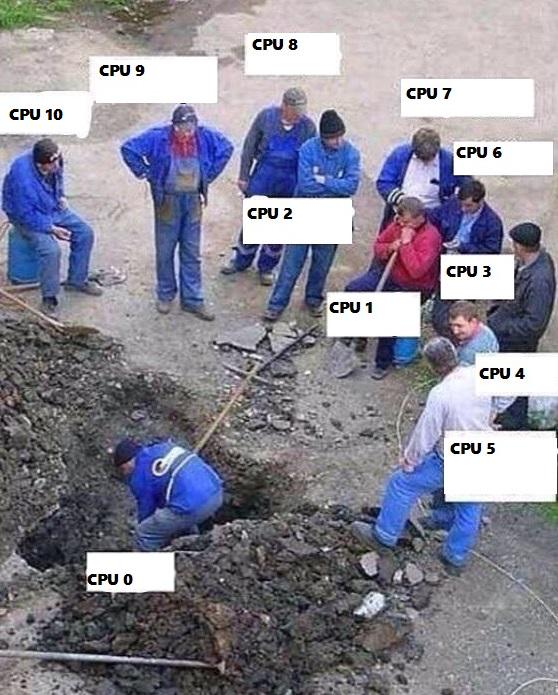

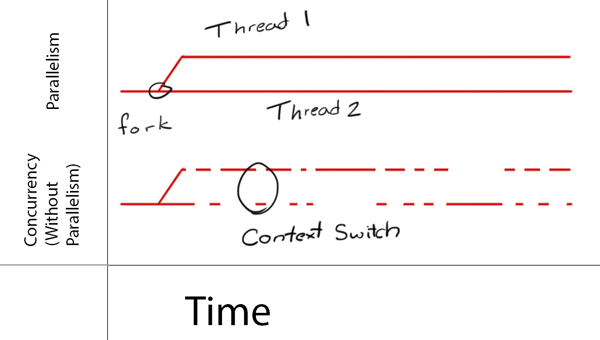

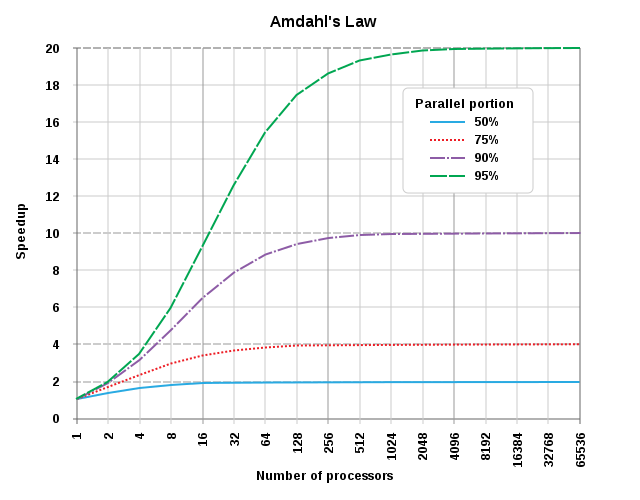

Each additional process will increase the communication overhead and decrease the available RAM, so you rarely get a full nx speedup. Depending on which problem you are solving, the communication overhead can even get so large that you can see very significant slowdowns

hyperthreading can give up to a 30% performance gain if there are enough spare computing resources. This works if, for example, you have a mix of floating-point and integer arithmetic 

* Split your jobs into independent units of work.
* If your workers take varying amounts of time, then consider randomizing the sequence of work (another example would be for processing variable-sized files).
* Sorting your work queue so slowest jobs go first maybe an equally useful strategy.
* Use the default chunksize unless you have verified reasons for adjusting it.
* Align the number of jobs with the number of physical CPUs (again, the default chunksize takes care of this for you, although it will use any hyperthreads by default, which may not offer any additional gain).

## Multithreading

In [6]:
import urllib2
import threading

class FetchUrls(threading.Thread):
    """
    Thread checking URLs.
    """

    def __init__(self, urls, output):
        """
        Constructor.

        @param urls list of urls to check
        @param output file to write urls output
        """
        threading.Thread.__init__(self)
        self.urls = urls
        self.output = output
    
    def run(self):
        """
        Thread run method. Check URLs one by one.
        """
        while self.urls:
            url = self.urls.pop()
            req = urllib2.Request(url)
            try:
                d = urllib2.urlopen(req)
            except urllib2.URLError, e:
                print('URL %s failed: %s' % (url, e.reason))
            self.output.write(d.read())
            print('write done by %s' % self.name)
            print('URL %s fetched by %s' % (url, self.name))


def main():
    # list 1 of urls to fetch
    urls1 = ['http://www.google.com', 'http://www.facebook.com']
    # list 2 of urls to fetch
    urls2 = ['http://www.yahoo.com', 'http://www.youtube.com']
    f = open('output.txt', 'w+')
    t1 = FetchUrls(urls1, f)
    t2 = FetchUrls(urls2, f)
    t1.start()
    t2.start()
    t1.join()
    t2.join()
    f.close()

if __name__ == '__main__':
    main()

write done by Thread-10
URL http://www.facebook.com fetched by Thread-10
write done by Thread-10
URL http://www.google.com fetched by Thread-10
write done by Thread-11
URL http://www.youtube.com fetched by Thread-11
write done by Thread-11
URL http://www.yahoo.com fetched by Thread-11


### Lock

In [9]:
class FetchUrls(threading.Thread):

    def __init__(self, urls, output, lock):
        threading.Thread.__init__(self)
        self.urls = urls
        self.output = output
        self.lock = lock
    
    def run(self):
        while self.urls:
            url = self.urls.pop()
            req = urllib2.Request(url)
            try:
                d = urllib2.urlopen(req)
            except urllib2.URLError, e:
                print('URL %s failed: %s' % (url, e.reason))
            self.lock.acquire()
            print('lock acquired by %s' % self.name)
            self.output.write(d.read())
            print('write done by %s' % self.name)
            print('lock released by %s' % self.name)
            self.lock.release()
            print 'URL %s fetched by %s' % (url, self.name)

    # same as above but using `with`
    def run_with_lock(self):
        while self.urls:
            url = self.urls.pop()
            req = urllib2.Request(url)
            try:
                d = urllib2.urlopen(req)
            except urllib2.URLError, e:
                print('URL %s failed: %s' % (url, e.reason))
            with self.lock:
                print('lock acquired by %s' % self.name)
                self.output.write(d.read())
                print('write done by %s' % self.name)
            print('lock released by %s' % self.name)
            print('URL %s fetched by %s' % (url, self.name))
            
def main():
    lock = threading.Lock()
    urls1 = ['http://www.google.com', 'http://www.facebook.com']
    urls2 = ['http://www.yahoo.com', 'http://www.youtube.com']
    f = open('output.txt', 'w+')
    t1 = FetchUrls(urls1, f, lock)
    t2 = FetchUrls(urls2, f, lock)
    t1.start()
    t2.start()
    t1.join()
    t2.join()
    f.close()

if __name__ == '__main__':
    main()

lock acquired by Thread-14
write done by Thread-14
lock released by Thread-14
URL http://www.youtube.com fetched by Thread-14lock acquired by Thread-13

write done by Thread-13
lock released by Thread-13
URL http://www.facebook.com fetched by Thread-13
lock acquired by Thread-13
write done by Thread-13
lock released by Thread-13
URL http://www.google.com fetched by Thread-13
lock acquired by Thread-14
write done by Thread-14
lock released by Thread-14
URL http://www.yahoo.com fetched by Thread-14


#### Lock internals

Python/thread_pthread.h

In [ ]:
PyThread_type_lock
PyThread_allocate_lock(void)
{
    sem_t *lock;
    int status, error = 0;

    dprintf(("PyThread_allocate_lock called\n"));
    if (!initialized)
        PyThread_init_thread();

    lock = (sem_t *)malloc(sizeof(sem_t));

    if (lock) {
        status = sem_init(lock,0,1);
        CHECK_STATUS("sem_init");

        if (error) {
            free((void *)lock);
            lock = NULL;
        }
    }

    dprintf(("PyThread_allocate_lock() -> %p\n", lock));
    return (PyThread_type_lock)lock;
}

void
PyThread_free_lock(PyThread_type_lock lock)
{
    sem_t *thelock = (sem_t *)lock;
    int status, error = 0;

    (void) error; /* silence unused-but-set-variable warning */
    dprintf(("PyThread_free_lock(%p) called\n", lock));

    if (!thelock)
        return;

    status = sem_destroy(thelock);
    CHECK_STATUS("sem_destroy");

    free((void *)thelock);
}

int
PyThread_acquire_lock(PyThread_type_lock lock, int waitflag)
{
    int success;
    sem_t *thelock = (sem_t *)lock;
    int status, error = 0;

    (void) error; /* silence unused-but-set-variable warning */
    dprintf(("PyThread_acquire_lock(%p, %d) called\n", lock, waitflag));

    do {
        if (waitflag)
            status = fix_status(sem_wait(thelock));
        else
            status = fix_status(sem_trywait(thelock));
    } while (status == EINTR); /* Retry if interrupted by a signal */

    if (waitflag) {
        CHECK_STATUS("sem_wait");
    } else if (status != EAGAIN) {
        CHECK_STATUS("sem_trywait");
    }

    success = (status == 0) ? 1 : 0;

    dprintf(("PyThread_acquire_lock(%p, %d) -> %d\n", lock, waitflag, success));
    return success;
}

void
PyThread_release_lock(PyThread_type_lock lock)
{
    sem_t *thelock = (sem_t *)lock;
    int status, error = 0;

    (void) error; /* silence unused-but-set-variable warning */
    dprintf(("PyThread_release_lock(%p) called\n", lock));

    status = sem_post(thelock);
    CHECK_STATUS("sem_post");
}


### RLock

In [ ]:
def RLock(*args, **kwargs):
    """Factory function that returns a new reentrant lock.
    A reentrant lock must be released by the thread that acquired it. Once a
    thread has acquired a reentrant lock, the same thread may acquire it again
    without blocking; the thread must release it once for each time it has
    acquired it.
    """
    return _RLock(*args, **kwargs)

class _RLock(_Verbose):
    """A reentrant lock must be released by the thread that acquired it. Once a
       thread has acquired a reentrant lock, the same thread may acquire it
       again without blocking; the thread must release it once for each time it
       has acquired it.
    """

    def __init__(self, verbose=None):
        _Verbose.__init__(self, verbose)
        self.__block = _allocate_lock()
        self.__owner = None
        self.__count = 0

    def __repr__(self):
        owner = self.__owner
        try:
            owner = _active[owner].name
        except KeyError:
            pass
        return "<%s owner=%r count=%d>" % (
                self.__class__.__name__, owner, self.__count)

    def acquire(self, blocking=1):
        """Acquire a lock, blocking or non-blocking.
        When invoked without arguments: if this thread already owns the lock,
        increment the recursion level by one, and return immediately. Otherwise,
        if another thread owns the lock, block until the lock is unlocked. Once
        the lock is unlocked (not owned by any thread), then grab ownership, set
        the recursion level to one, and return. If more than one thread is
        blocked waiting until the lock is unlocked, only one at a time will be
        able to grab ownership of the lock. There is no return value in this
        case.
        When invoked with the blocking argument set to true, do the same thing
        as when called without arguments, and return true.
        When invoked with the blocking argument set to false, do not block. If a
        call without an argument would block, return false immediately;
        otherwise, do the same thing as when called without arguments, and
        return true.
        """
        me = _get_ident()
        if self.__owner == me:
            self.__count = self.__count + 1
            if __debug__:
                self._note("%s.acquire(%s): recursive success", self, blocking)
            return 1
        rc = self.__block.acquire(blocking)
        if rc:
            self.__owner = me
            self.__count = 1
            if __debug__:
                self._note("%s.acquire(%s): initial success", self, blocking)
        else:
            if __debug__:
                self._note("%s.acquire(%s): failure", self, blocking)
        return rc

    __enter__ = acquire

    def release(self):
        """Release a lock, decrementing the recursion level.
        If after the decrement it is zero, reset the lock to unlocked (not owned
        by any thread), and if any other threads are blocked waiting for the
        lock to become unlocked, allow exactly one of them to proceed. If after
        the decrement the recursion level is still nonzero, the lock remains
        locked and owned by the calling thread.
        Only call this method when the calling thread owns the lock. A
        RuntimeError is raised if this method is called when the lock is
        unlocked.
        There is no return value.
        """
        if self.__owner != _get_ident():
            raise RuntimeError("cannot release un-acquired lock")
        self.__count = count = self.__count - 1
        if not count:
            self.__owner = None
            self.__block.release()
            if __debug__:
                self._note("%s.release(): final release", self)
        else:
            if __debug__:
                self._note("%s.release(): non-final release", self)

    def __exit__(self, t, v, tb):
        self.release()

### Condition

In [ ]:
import random

class Producer(threading.Thread):
    """
    Produces random integers to a list
    """

    def __init__(self, integers, condition):
        """
        Constructor.

        @param integers list of integers
        @param condition condition synchronization object
        """
        threading.Thread.__init__(self)
        self.integers = integers
        self.condition = condition
    
    def run(self):
        """
        Thread run method. Append random integers to the integers list
        at random time.
        """
        while True:
            integer = random.randint(0, 256)
            self.condition.acquire()
            print('condition acquired by %s' % self.name)
            self.integers.append(integer) 
            print('%d appended to list by %s' % (integer, self.name))
            print('condition notified by %s' % self.name)
            self.condition.notify()
            print('condition released by %s' % self.name)
            self.condition.release()
            time.sleep(1)

            
class Consumer(threading.Thread):
    """
    Consumes random integers from a list
    """

    def __init__(self, integers, condition):
        """
        Constructor.

        @param integers list of integers
        @param condition condition synchronization object
        """
        threading.Thread.__init__(self)
        self.integers = integers
        self.condition = condition
    
    def run(self):
        """
        Thread run method. Consumes integers from list
        """
        while True:
            self.condition.acquire()
            print('condition acquired by %s' % self.name)
            while True:
                if self.integers:
                    integer = self.integers.pop()
                    print('%d popped from list by %s' % (integer, self.name))
                    break
                print('condition wait by %s' % self.name)
                self.condition.wait()
            print('condition released by %s' % self.name)
            self.condition.release()

In [ ]:
class _Condition(_Verbose):
    """Condition variables allow one or more threads to wait until they are
       notified by another thread.
    """

    def __init__(self, lock=None, verbose=None):
        _Verbose.__init__(self, verbose)
        if lock is None:
            lock = RLock()
        self.__lock = lock
        # Export the lock's acquire() and release() methods
        self.acquire = lock.acquire
        self.release = lock.release
        # If the lock defines _release_save() and/or _acquire_restore(),
        # these override the default implementations (which just call
        # release() and acquire() on the lock).  Ditto for _is_owned().
        try:
            self._release_save = lock._release_save
        except AttributeError:
            pass
        try:
            self._acquire_restore = lock._acquire_restore
        except AttributeError:
            pass
        try:
            self._is_owned = lock._is_owned
        except AttributeError:
            pass
        self.__waiters = []

    def __enter__(self):
        return self.__lock.__enter__()

    def __exit__(self, *args):
        return self.__lock.__exit__(*args)

    def __repr__(self):
        return "<Condition(%s, %d)>" % (self.__lock, len(self.__waiters))

    def _release_save(self):
        self.__lock.release()           # No state to save

    def _acquire_restore(self, x):
        self.__lock.acquire()           # Ignore saved state

    def _is_owned(self):
        # Return True if lock is owned by current_thread.
        # This method is called only if __lock doesn't have _is_owned().
        if self.__lock.acquire(0):
            self.__lock.release()
            return False
        else:
            return True

    def wait(self, timeout=None):
        """Wait until notified or until a timeout occurs.
        If the calling thread has not acquired the lock when this method is
        called, a RuntimeError is raised.
        This method releases the underlying lock, and then blocks until it is
        awakened by a notify() or notifyAll() call for the same condition
        variable in another thread, or until the optional timeout occurs. Once
        awakened or timed out, it re-acquires the lock and returns.
        When the timeout argument is present and not None, it should be a
        floating point number specifying a timeout for the operation in seconds
        (or fractions thereof).
        When the underlying lock is an RLock, it is not released using its
        release() method, since this may not actually unlock the lock when it
        was acquired multiple times recursively. Instead, an internal interface
        of the RLock class is used, which really unlocks it even when it has
        been recursively acquired several times. Another internal interface is
        then used to restore the recursion level when the lock is reacquired.
        """
        if not self._is_owned():
            raise RuntimeError("cannot wait on un-acquired lock")
        waiter = _allocate_lock()
        waiter.acquire()
        self.__waiters.append(waiter)
        saved_state = self._release_save()
        try:    # restore state no matter what (e.g., KeyboardInterrupt)
            if timeout is None:
                waiter.acquire()
                if __debug__:
                    self._note("%s.wait(): got it", self)
            else:
                # Balancing act:  We can't afford a pure busy loop, so we
                # have to sleep; but if we sleep the whole timeout time,
                # we'll be unresponsive.  The scheme here sleeps very
                # little at first, longer as time goes on, but never longer
                # than 20 times per second (or the timeout time remaining).
                endtime = _time() + timeout
                delay = 0.0005 # 500 us -> initial delay of 1 ms
                while True:
                    gotit = waiter.acquire(0)
                    if gotit:
                        break
                    remaining = endtime - _time()
                    if remaining <= 0:
                        break
                    delay = min(delay * 2, remaining, .05)
                    _sleep(delay)
                if not gotit:
                    if __debug__:
                        self._note("%s.wait(%s): timed out", self, timeout)
                    try:
                        self.__waiters.remove(waiter)
                    except ValueError:
                        pass
                else:
                    if __debug__:
                        self._note("%s.wait(%s): got it", self, timeout)
        finally:
            self._acquire_restore(saved_state)

    def notify(self, n=1):
        """Wake up one or more threads waiting on this condition, if any.
        If the calling thread has not acquired the lock when this method is
        called, a RuntimeError is raised.
        This method wakes up at most n of the threads waiting for the condition
        variable; it is a no-op if no threads are waiting.
        """
        if not self._is_owned():
            raise RuntimeError("cannot notify on un-acquired lock")
        __waiters = self.__waiters
        waiters = __waiters[:n]
        if not waiters:
            if __debug__:
                self._note("%s.notify(): no waiters", self)
            return
        self._note("%s.notify(): notifying %d waiter%s", self, n,
                   n!=1 and "s" or "")
        for waiter in waiters:
            waiter.release()
            try:
                __waiters.remove(waiter)
            except ValueError:
                pass

    def notifyAll(self):
        """Wake up all threads waiting on this condition.
        If the calling thread has not acquired the lock when this method
        is called, a RuntimeError is raised.
        """
        self.notify(len(self.__waiters))

    notify_all = notifyAll

### Semaphore

In [ ]:
class _Semaphore(_Verbose):
    """Semaphores manage a counter representing the number of release() calls
       minus the number of acquire() calls, plus an initial value. The acquire()
       method blocks if necessary until it can return without making the counter
       negative. If not given, value defaults to 1.
    """

    # After Tim Peters' semaphore class, but not quite the same (no maximum)

    def __init__(self, value=1, verbose=None):
        if value < 0:
            raise ValueError("semaphore initial value must be >= 0")
        _Verbose.__init__(self, verbose)
        self.__cond = Condition(Lock())
        self.__value = value

    def acquire(self, blocking=1):
        """Acquire a semaphore, decrementing the internal counter by one.
        When invoked without arguments: if the internal counter is larger than
        zero on entry, decrement it by one and return immediately. If it is zero
        on entry, block, waiting until some other thread has called release() to
        make it larger than zero. This is done with proper interlocking so that
        if multiple acquire() calls are blocked, release() will wake exactly one
        of them up. The implementation may pick one at random, so the order in
        which blocked threads are awakened should not be relied on. There is no
        return value in this case.
        When invoked with blocking set to true, do the same thing as when called
        without arguments, and return true.
        When invoked with blocking set to false, do not block. If a call without
        an argument would block, return false immediately; otherwise, do the
        same thing as when called without arguments, and return true.
        """
        rc = False
        with self.__cond:
            while self.__value == 0:
                if not blocking:
                    break
                if __debug__:
                    self._note("%s.acquire(%s): blocked waiting, value=%s",
                            self, blocking, self.__value)
                self.__cond.wait()
            else:
                self.__value = self.__value - 1
                if __debug__:
                    self._note("%s.acquire: success, value=%s",
                            self, self.__value)
                rc = True
        return rc

    __enter__ = acquire

    def release(self):
        """Release a semaphore, incrementing the internal counter by one.
        When the counter is zero on entry and another thread is waiting for it
        to become larger than zero again, wake up that thread.
        """
        with self.__cond:
            self.__value = self.__value + 1
            if __debug__:
                self._note("%s.release: success, value=%s",
                        self, self.__value)
            self.__cond.notify()

    def __exit__(self, t, v, tb):
        self.release()

### Event

In [ ]:
class Producer(threading.Thread):
    """
    Produces random integers to a list
    """

    def __init__(self, integers, event):
        """
        Constructor.

        @param integers list of integers
        @param event event synchronization object
        """
        threading.Thread.__init__(self)
        self.integers = integers
        self.event = event
    
    def run(self):
        """
        Thread run method. Append random integers to the integers list
        at random time.
        """
        while True:
            integer = random.randint(0, 256)
            self.integers.append(integer) 
            print('%d appended to list by %s' % (integer, self.name))
            print('event set by %s' % self.name)
            self.event.set()
            self.event.clear()
            print('event cleared by %s' % self.name)
            time.sleep(1)

            
class Consumer(threading.Thread):
    """
    Consumes random integers from a list
    """

    def __init__(self, integers, event):
        """
        Constructor.

        @param integers list of integers
        @param event event synchronization object
        """
        threading.Thread.__init__(self)
        self.integers = integers
        self.event = event
    
    def run(self):
        """
        Thread run method. Consumes integers from list
        """
        while True:
            self.event.wait()
            try:
                integer = self.integers.pop()
                print('%d popped from list by %s' % (integer, self.name))
            except IndexError:
                # catch pop on empty list
                time.sleep(1)

In [ ]:
import threading

SHOULD_EXIT = threading.Event()
DB_LOCK = threading.Lock()

def check_for_exit():
    if SHOULD_EXIT.is_set():
        raise SystemExit


def loader_cycle(config, db_config, worker_name):
    # ...
    # skipped code
    # ...

    while True:
        tmp_fullname = None
        handled_files = None
        remote_fns = None
        task_id = None
        try:
            check_for_exit()
            try:
                task = acquire_task(config, worker_name, host_name)
            except Exception, e:
                logging.warning("Cannot acquire task: %s", repr(e))
                task = None

            if task is None:
                SHOULD_EXIT.wait(config['idle_sleep'])
                check_for_exit()
                continue
    # ...
    # skipped code
    # ...

def send_heartbeat(conn, host):
    update_query = """
        REPLACE INTO `servers`
        SET `host` = %s, `heartbeat` = NOW()
        """
    try:
        with DB_LOCK:
            conn.execute(update_query, host)
    except Exception, e:
        logging.warning("Cannot send heartbeat: %s", repr(e))


In [ ]:

class _Event(_Verbose):
    """A factory function that returns a new event object. An event manages a
       flag that can be set to true with the set() method and reset to false
       with the clear() method. The wait() method blocks until the flag is true.
    """

    # After Tim Peters' event class (without is_posted())

    def __init__(self, verbose=None):
        _Verbose.__init__(self, verbose)
        self.__cond = Condition(Lock())
        self.__flag = False

    def _reset_internal_locks(self):
        # private!  called by Thread._reset_internal_locks by _after_fork()
        self.__cond.__init__(Lock())

    def isSet(self):
        'Return true if and only if the internal flag is true.'
        return self.__flag

    is_set = isSet

    def set(self):
        """Set the internal flag to true.
        All threads waiting for the flag to become true are awakened. Threads
        that call wait() once the flag is true will not block at all.
        """
        with self.__cond:
            self.__flag = True
            self.__cond.notify_all()

    def clear(self):
        """Reset the internal flag to false.
        Subsequently, threads calling wait() will block until set() is called to
        set the internal flag to true again.
        """
        with self.__cond:
            self.__flag = False

    def wait(self, timeout=None):
        """Block until the internal flag is true.
        If the internal flag is true on entry, return immediately. Otherwise,
        block until another thread calls set() to set the flag to true, or until
        the optional timeout occurs.
        When the timeout argument is present and not None, it should be a
        floating point number specifying a timeout for the operation in seconds
        (or fractions thereof).
        This method returns the internal flag on exit, so it will always return
        True except if a timeout is given and the operation times out.
        """
        with self.__cond:
            if not self.__flag:
                self.__cond.wait(timeout)
            return self.__flag

### Queue

In [ ]:
class Producer(threading.Thread):
    """
    Produces random integers to a list
    """

    def __init__(self, queue):
        """
        Constructor.

        @param integers list of integers
        @param queue queue synchronization object
        """
        threading.Thread.__init__(self)
        self.queue = queue
    
    def run(self):
        """
        Thread run method. Append random integers to the integers list at
        random time.
        """
        while True:
            integer = random.randint(0, 256)
            self.queue.put(integer) 
            print('%d put to queue by %s' % (integer, self.name))
            time.sleep(1)
            
            
class Consumer(threading.Thread):
    """
    Consumes random integers from a list
    """

    def __init__(self, queue):
        """
        Constructor.

        @param integers list of integers
        @param queue queue synchronization object
        """
        threading.Thread.__init__(self)
        self.queue = queue
    
    def run(self):
        """
        Thread run method. Consumes integers from list
        """
        while True:
            integer = self.queue.get()
            print('%d popped from list by %s' % (integer, self.name))
            self.queue.task_done()

In [ ]:
class Queue:
    """Create a queue object with a given maximum size.
    If maxsize is <= 0, the queue size is infinite.
    """
    def __init__(self, maxsize=0):
        self.maxsize = maxsize
        self._init(maxsize)
        # mutex must be held whenever the queue is mutating.  All methods
        # that acquire mutex must release it before returning.  mutex
        # is shared between the three conditions, so acquiring and
        # releasing the conditions also acquires and releases mutex.
        self.mutex = _threading.Lock()
        # Notify not_empty whenever an item is added to the queue; a
        # thread waiting to get is notified then.
        self.not_empty = _threading.Condition(self.mutex)
        # Notify not_full whenever an item is removed from the queue;
        # a thread waiting to put is notified then.
        self.not_full = _threading.Condition(self.mutex)
        # Notify all_tasks_done whenever the number of unfinished tasks
        # drops to zero; thread waiting to join() is notified to resume
        self.all_tasks_done = _threading.Condition(self.mutex)
        self.unfinished_tasks = 0

    def task_done(self):
        """Indicate that a formerly enqueued task is complete.
        Used by Queue consumer threads.  For each get() used to fetch a task,
        a subsequent call to task_done() tells the queue that the processing
        on the task is complete.
        If a join() is currently blocking, it will resume when all items
        have been processed (meaning that a task_done() call was received
        for every item that had been put() into the queue).
        Raises a ValueError if called more times than there were items
        placed in the queue.
        """
        self.all_tasks_done.acquire()
        try:
            unfinished = self.unfinished_tasks - 1
            if unfinished <= 0:
                if unfinished < 0:
                    raise ValueError('task_done() called too many times')
                self.all_tasks_done.notify_all()
            self.unfinished_tasks = unfinished
        finally:
            self.all_tasks_done.release()

    def join(self):
        """Blocks until all items in the Queue have been gotten and processed.
        The count of unfinished tasks goes up whenever an item is added to the
        queue. The count goes down whenever a consumer thread calls task_done()
        to indicate the item was retrieved and all work on it is complete.
        When the count of unfinished tasks drops to zero, join() unblocks.
        """
        self.all_tasks_done.acquire()
        try:
            while self.unfinished_tasks:
                self.all_tasks_done.wait()
        finally:
            self.all_tasks_done.release()

    def qsize(self):
        """Return the approximate size of the queue (not reliable!)."""
        self.mutex.acquire()
        n = self._qsize()
        self.mutex.release()
        return n

    def empty(self):
        """Return True if the queue is empty, False otherwise (not reliable!)."""
        self.mutex.acquire()
        n = not self._qsize()
        self.mutex.release()
        return n

    def full(self):
        """Return True if the queue is full, False otherwise (not reliable!)."""
        self.mutex.acquire()
        n = 0 < self.maxsize == self._qsize()
        self.mutex.release()
        return n

    def put(self, item, block=True, timeout=None):
        """Put an item into the queue.
        If optional args 'block' is true and 'timeout' is None (the default),
        block if necessary until a free slot is available. If 'timeout' is
        a non-negative number, it blocks at most 'timeout' seconds and raises
        the Full exception if no free slot was available within that time.
        Otherwise ('block' is false), put an item on the queue if a free slot
        is immediately available, else raise the Full exception ('timeout'
        is ignored in that case).
        """
        self.not_full.acquire()
        try:
            if self.maxsize > 0:
                if not block:
                    if self._qsize() == self.maxsize:
                        raise Full
                elif timeout is None:
                    while self._qsize() == self.maxsize:
                        self.not_full.wait()
                elif timeout < 0:
                    raise ValueError("'timeout' must be a non-negative number")
                else:
                    endtime = _time() + timeout
                    while self._qsize() == self.maxsize:
                        remaining = endtime - _time()
                        if remaining <= 0.0:
                            raise Full
                        self.not_full.wait(remaining)
            self._put(item)
            self.unfinished_tasks += 1
            self.not_empty.notify()
        finally:
            self.not_full.release()

    def put_nowait(self, item):
        """Put an item into the queue without blocking.
        Only enqueue the item if a free slot is immediately available.
        Otherwise raise the Full exception.
        """
        return self.put(item, False)

    def get(self, block=True, timeout=None):
        """Remove and return an item from the queue.
        If optional args 'block' is true and 'timeout' is None (the default),
        block if necessary until an item is available. If 'timeout' is
        a non-negative number, it blocks at most 'timeout' seconds and raises
        the Empty exception if no item was available within that time.
        Otherwise ('block' is false), return an item if one is immediately
        available, else raise the Empty exception ('timeout' is ignored
        in that case).
        """
        self.not_empty.acquire()
        try:
            if not block:
                if not self._qsize():
                    raise Empty
            elif timeout is None:
                while not self._qsize():
                    self.not_empty.wait()
            elif timeout < 0:
                raise ValueError("'timeout' must be a non-negative number")
            else:
                endtime = _time() + timeout
                while not self._qsize():
                    remaining = endtime - _time()
                    if remaining <= 0.0:
                        raise Empty
                    self.not_empty.wait(remaining)
            item = self._get()
            self.not_full.notify()
            return item
        finally:
            self.not_empty.release()

    def get_nowait(self):
        """Remove and return an item from the queue without blocking.
        Only get an item if one is immediately available. Otherwise
        raise the Empty exception.
        """
        return self.get(False)

    # Override these methods to implement other queue organizations
    # (e.g. stack or priority queue).
    # These will only be called with appropriate locks held

    # Initialize the queue representation
    def _init(self, maxsize):
        self.queue = deque()

    def _qsize(self, len=len):
        return len(self.queue)

    # Put a new item in the queue
    def _put(self, item):
        self.q.append(item)

### Pool

In [ ]:
import time 
import threading 
import Queue 
import urllib2 

class Fetcher(threading.Thread): 
    def __init__(self, queue): 
        threading.Thread.__init__(self)
        self._queue = queue 

    def run(self):
        while True: 
            content = self._queue.get() 
            if isinstance(content, str) and content == 'quit':
                break
            response = urllib2.urlopen(content)
        print('Bye byes!')


def inject():
    urls = [
        'http://www.python.org', 'http://www.yahoo.com'
        'http://www.scala.org', 'http://www.google.com'
        # etc.. 
    ]
    queue = Queue.Queue()
    worker_threads = build_worker_pool(queue, 4)
    start_time = time.time()

    # Add the urls to process
    for url in urls: 
        queue.put(url)  
    # Add the poison pill
    for worker in worker_threads:
        queue.put('quit')
    for worker in worker_threads:
        worker.join()

    print('Done! Time taken: {}'.format(time.time() - start_time))

def build_worker_pool(queue, size):
    workers = []
    for _ in range(size):
        worker = Fetcher(queue)
        worker.start() 
        workers.append(worker)
    return workers

if __name__ == '__main__':
    inject()

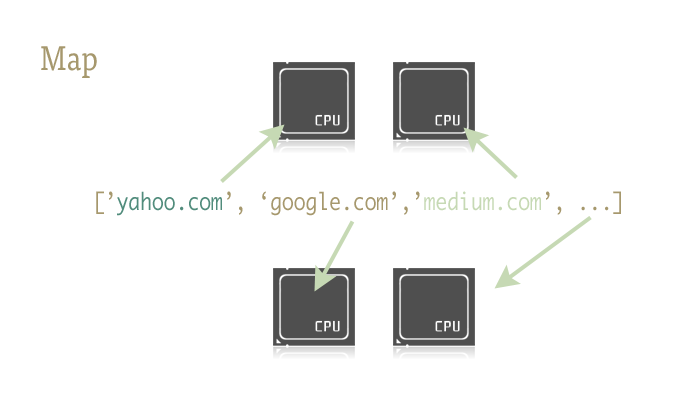

In [ ]:
import urllib2 
from multiprocessing.dummy import Pool as ThreadPool 

urls = [
  'http://www.python.org', 
  'http://www.python.org/about/',
  'http://www.onlamp.com/pub/a/python/2003/04/17/metaclasses.html',
  'http://www.python.org/doc/',
  'http://www.python.org/download/',
  'http://www.python.org/getit/',
  'http://www.python.org/community/',
  'https://wiki.python.org/moin/',
  'http://planet.python.org/',
  'https://wiki.python.org/moin/LocalUserGroups',
  'http://www.python.org/psf/',
  'http://docs.python.org/devguide/',
  'http://www.python.org/community/awards/'
  # etc.. 
  ]

# Make the Pool of workers
pool = ThreadPool(4) 
# Open the urls in their own threads
# and return the results
results = pool.map(urllib2.urlopen, urls)
#close the pool and wait for the work to finish 
pool.close() 
pool.join() 

### Based on true story

In [ ]:
def query_pixel_k(config, vk_id):
    url = "http://%s/k?vk_id=%s" % (config["PIXEL_K_HOST"], vk_id)
    response = requests.get(url, headers={'referer': "http://vk.com"}, timeout=5)
    try:
        response.raise_for_status()
    except Exception, e:
        logging.error("pixel_k request error: %s" % e)
        return False
    return True


def refresh_main(config):
    logging.info("VK profiles refresher started")
    num_profiles_processed = num_profiles_refreshed = 0
    snap_dirs = filter(os.path.isdir, glob.glob(config["SNAPSHOTS_DIR_PATTERN"]))
    logging.info("%s snap dir(s) specified" % len(snap_dirs))
    sleep = 1.0 / 170
    for snap_dir in snap_dirs:
        logging.info("Looking for snaps in %s" % snap_dir)
        for profile in iter_vk_profiles(snap_dir, config["VK_PROFILES_SPACE"]):
            num_profiles_processed += 1
            if is_stall(config, profile) or (profile.is_incomplete() and not profile.refreshed_recently()):
                num_profiles_refreshed += 1
                query_pixel_k(config, profile.vk_id)
                time.sleep(sleep)
    logging.info("%s profiles processed, %s refreshed" % (num_profiles_processed, num_profiles_refreshed))
    if not num_profiles_processed:
        logging.error("No profiles processed during run")

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool

def refresh_main(config):
    logging.info("VK profiles refresher started")
    nprocessed = nrefreshed = 0
    snap_dirs = filter(os.path.isdir, glob.glob(config["SNAPSHOTS_DIR_PATTERN"]))
    logging.info("%s snap dir(s) specified" % len(snap_dirs))
    for snap_dir in snap_dirs:
        logging.info("Looking for snaps in %s" % snap_dir)
        pool = ThreadPool(config["NUM_WORKERS"])
        args_gen = ((config, t) for t in iter_snapshot(snap_dir, config["VK_PROFILES_SPACE"]))
        logging.info("Starting pool of %d threads working on snapshot" % (config["NUM_WORKERS"],))
        for refreshed in pool.imap_unordered(update_vk_profile, args_gen, chunksize=1000):
            nprocessed += 1
            nrefreshed += refreshed
            if not nrefreshed % 1000:
                logging.info("Processed: %s. Refreshed: %s" % (nprocessed, nrefreshed))
    logging.info("%s profiles processed, %s refreshed" % (nprocessed, nrefreshed))
    if not nprocessed:
        logging.error("No profiles processed during run")


In [ ]:
import Queue
import threading

_sentinel = object()


class VKProfileUpdater(threading.Thread):
    def __init__(self, queue, config):
        threading.Thread.__init__(self)
        self.daemon = True
        self.queue = queue
        self.config = config
        self.refreshed = self.processed = 0
        self.tnt_vk_profiles2 = self.memc_uid = None
        ignore_api_errors = config["VK"].get("ignore_errors", True)
        self.vk_api = VKAPI(config["VK"]["token"], config["VK"]["salt"], ignore_errors=ignore_api_errors)

    # ...
    # skipped code
    # ...

    def work(self, tuples):
        profiles = (VKProfile.from_tuple(t) for t in tuples if t)
        results = self.update_profiles(p for p in profiles if p and (p.needs_update() or self.config["FORCE"]))
        for updated in results:
            self.processed += 1
            self.refreshed += bool(updated)

    def run(self):
        try:
            self._set_connections()
        except Exception, e:
            logging.exception("Cannot set requried connections: %s" % e)
            return
        while True:
            j = self.queue.get(block=True, timeout=None)
            if j == _sentinel:
                self.queue.task_done()
                break
            try:
                self.work(j)
            except Exception as e:
                logging.exception("%s" % repr(e))
            self.queue.task_done()


def refresh_main(config):
    logging.info("VK profiles refresher started")
    read = nprocessed = nrefreshed = 0
    snap_dirs = filter(os.path.isdir, glob.glob(config["SNAPSHOTS_DIR_PATTERN"]))
    logging.info("%s snap dir(s) specified" % len(snap_dirs))
    tuples_queue = Queue.Queue(maxsize=config["NUM_WORKERS"])
    logging.info("Starting pool of %d threads working on snapshot" % (config["NUM_WORKERS"],))
    workers = []
    for _ in range(config["NUM_WORKERS"]):
        worker = VKProfileUpdater(tuples_queue, config)
        worker.start()
        workers.append(worker)
    for snap_dir in snap_dirs:
        logging.info("Looking for snaps in %s" % snap_dir)
        it = iter_snapshot(snap_dir, config["VK_PROFILES_SPACE"])
        chunk = list(itertools.islice(it, config["CHUNK_SIZE"]))
        while all(w.is_alive() for w in workers):
            if not chunk:
                break
            try:
                tuples_queue.put(chunk, block=False, timeout=60)
            except Queue.Full:
                continue
            read += len(chunk)
            logging.info("Read: %s. In queue: %s * %s" % (read, tuples_queue.qsize(), config["CHUNK_SIZE"]))
            chunk = list(itertools.islice(it, config["CHUNK_SIZE"]))
        else:
            logging.error("Not all workers alive. Exiting")
            return

    for _ in workers:
        tuples_queue.put(_sentinel)
    logging.info("Waiting for queue to empty")
    while tuples_queue.qsize():
        logging.info("Queue size: %s * %s" % (tuples_queue.qsize(), config["CHUNK_SIZE"]))
        time.sleep(10)
    for w in workers:
        w.join()

    nrefreshed = sum(w.refreshed for w in workers)
    nprocessed = sum(w.processed for w in workers)
    logging.info("%s profiles processed, %s refreshed" % (nprocessed, nrefreshed))
    if not nprocessed:
        logging.error("No profiles processed during run")


There is quite an overhead to using a Queue, due to the pickling and synchronization. If your task has a long completion time (at least a sizable fraction of a second) with a small amount of communication, then a Queue approach might be the right answer. You will have to verify whether the communication cost makes this approach useful enough

May be don't do that at home:

In [ ]:
class TarantoolThread(object):
    def __init__(self, tid):
        self.id = tid

    def execute(self, queue):
        mappings = {
            "vk_id": DeviceVKMappingTarantool,
            "ok_id": DeviceOKMappingTarantool,
            "email": DeviceEmailMappingTarantool,
        }
        records = 0
        while True:
            try:
                task = queue.get(timeout=0.1)
            except Queue.Empty:
                logging.info("[%s] Records inserted: %s" % (self.id, records))
                return
            tnt_pool, user_id_type, device_id_type, tuple_data = task
            try:
                mapping = tnt_pool.get(timeout=0.01)
            except Queue.Empty:
                mapping = mappings[user_id_type](config, device_id_type)
            ok = mapping.insert(tuple_data)
            if ok:
                records += 1
            tnt_pool.put(mapping)


def handle_binlog(config, binlog_path):
    pools = collections.defaultdict(Queue.Queue)
    queue = Queue.Queue()
    workers = []
    fn = binlog_path.split("/")[-1]
    for i in range(config["THREADS_PER_WORKER"]):
        tnt_thread = TarantoolThread("%s:%s" % (fn, i))
        thread = threading.Thread(target=tnt_thread.execute, args=(queue, ))
        workers.append((tnt_thread, thread))

    for (tnt_thread, thread) in workers:
        thread.start()

    logging.info("Processing %s" % binlog_path)
    s = time.time()
    for _, msg in lib.protoread(binlog_path):
        for user_id_type in config["USER_ID_TYPES"]:
            user_ids = msg.get(user_id_type, [])
            if not isinstance(user_ids, list):
                user_ids = [user_ids]
            for device_id_type in config["DEVICE_ID_TYPES"]:
                device_id = msg.get(device_id_type)
                if not device_id:
                    continue
                for user_id in user_ids:
                    td = {user_id_type: user_id, "device_id": device_id, "last_update": msg["timestamp"]}
                    queue.put((pools[(user_id_type, device_id_type)], user_id_type, device_id_type, td))

    for (tnt_thread, thread) in workers:
        thread.join()
    logging.info("%s processed in %s sec" % (binlog_path, time.time() - s))


def main(config):
    master = lib.Master(config["WORKERS"])
    binlogs_dir = config["BINLOGS_DIR"]

    while True:
        master.fetch()
        got_work = False
        if config["WORKERS"] - len(master.jobs) > 0:
            binlogs = [Binlog(binlogs_dir, fn) for fn in os.listdir(binlogs_dir) if BINLOG_RE.match(fn)]
            binlogs = sorted(binlogs, key=lambda b: b.datetime)
            logging.info("Found %s binlogs at %s" % (len(binlogs), binlogs_dir))
            for b in binlogs:
                got_work = True
                tmp_rename_path = os.path.join(b.dir, "." + b.name)
                finish_path = os.path.join(b.dir, "_" + b.name)
                d = {"path": tmp_rename_path, "finish_path": finish_path}
                os.rename(b.path, tmp_rename_path)
                master.job(handle_binlog, config, tmp_rename_path, multijob=d)

        while True:
            if not master.jobs or "result" not in master.jobs[0]:
                break

            finished = master.jobs.pop(0)
            logging.info("Finishing %s" % finished["multijob"]["path"])
            os.rename(finished["multijob"]["path"], finished["multijob"]["finish_path"])

        if not got_work:
            time.sleep(config["LOG_WAIT_TIMEOUT"])

# ...
# skipped code
# ...

## Multiprocessing

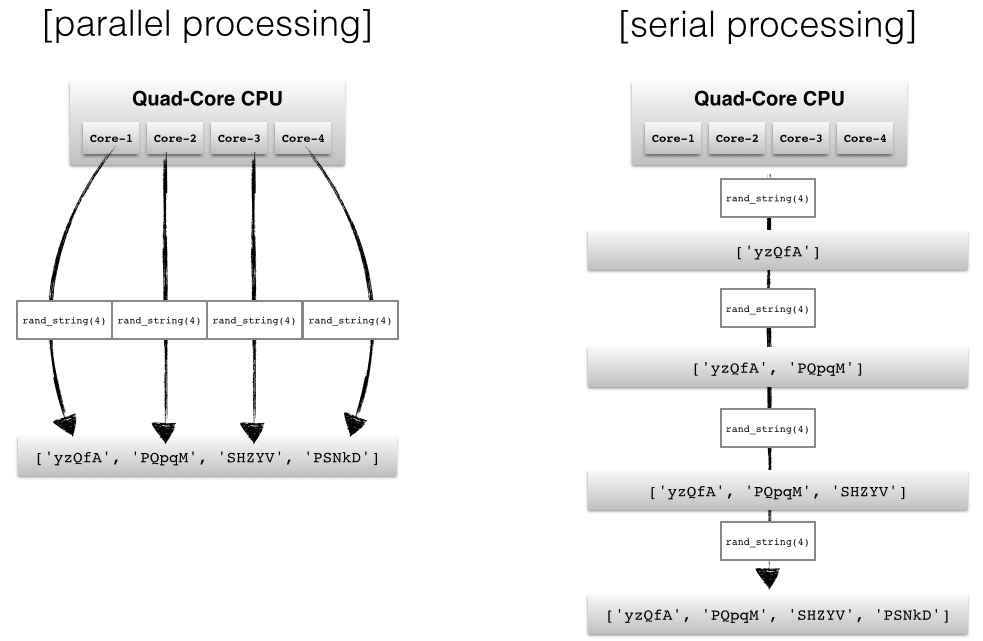

### Process

In [ ]:
'''import_mock.py'''
to_mock = None

In [ ]:
import import_mock
from multiprocessing import Process

class A(object):
    def __init__(self):
        self.a = 1
        self.b = 2
        self.c = 3

    def __getstate__(self):
        print('__getstate__')
        return { 'a': self.a, 'b': self.b, 'c': 0}

def func():
    import_mock.to_mock = 1
    a = A()
    return a

def func1(a):
    print(a.a, a.b, a.c)
    print(import_mock.to_mock)


if __name__ == '__main__':
    a = func()
    p = Process(target=func1, args=(a,))
    p.start()
    p.join()

In [ ]:
# Windows
__getstate__
1 2 0
None

# Linux
1 2 3
1

import_mock:

* On all platforms, the main process calls `func()`, which sets import_mock.to_mock to 1.
* On Unix-y platforms, that's what all new processes see: the `fork()` occurs after that, so 1 is the state all new processes inherit.
* On Windows, all new processes run the entire module "from scratch". So they each import their own, brand new version of import_mock. Only the main process calls `func()`, so only the main process sees to_mock change to 1. All other processes see the fresh None state.

a.a, a.b, a.c:
* Because of copy-on-write `fork()` semantics, it wasn't necessary to pickle `Process()` arguments on Unix-y systems, and so the implementation never did.
* However, without `fork()` it is necessary to pickle them on Windows - and so the implementation does.

The new processes are launched differently depending on the version of python and the platform on which the code is running e.g.:
* Windows uses `spawn` to create the new process.
* With unix systems and version earlier than 3.3, the processes are created using a `fork`. Note that this method does not respect the POSIX usage of fork and thus leads to unexpected behaviors, especially when interacting with other multiprocessing libraries.
* With unix system and version 3.4+, you can choose to start the new processes with either `fork`, `forkserver` or `spawn` using `multiprocessing.set_start_method` at the beginning of your program. `forkserver` and `spawn` methods are slower than forking but avoid some unexpected behaviors.

Using `fork`, a new process will be launched with the exact same state for all the current mutex but only the `MainThread` will be launched. This is unsafe as it could lead to race conditions e.g.:
If you use a `Lock` in `MainThread` and pass it to another thread which is supposed to lock it at some point. If the fork occurs simultaneously, the new process will start with a locked lock which will never be released as the second thread does not exist in this new process.

In [ ]:
import logging
from threading import Thread
from queue import Queue
from logging.handlers import QueueListener, QueueHandler
from multiprocessing import Pool

def setup_logging():
    _log_queue = Queue()
    QueueListener(
        _log_queue, logging.FileHandler("out.log")).start()
    logging.getLogger().addHandler(QueueHandler(_log_queue))

    # Our parent process is running a thread that
    # logs messages:
    def write_logs():
        while True:
            logging.error("hello, I just did something")
    Thread(target=write_logs).start()

def runs_in_subprocess():
    print("About to log...")
    logging.error("hello, I did something")
    print("...logged")

if __name__ == '__main__':
    setup_logging()
    while True:
        with Pool() as pool:
            pool.apply(runs_in_subprocess)

1. Whenever the thread in the parent process writes a log messages, it adds it to a `Queue`. That involves acquiring a lock.
2. If the `fork()` happens at the wrong time, the lock is copied in an acquired state.
3. The child process copies the parent’s logging configuration—including the queue.
4. Whenever the child process writes a log message, it tries to write it to the queue.
5. That means acquiring the lock, but the lock is already acquired.
6. The child process now waits for the lock to be released.
7. The lock will never be released, because the thread that would release it wasn’t copied over by the `fork()`.

### Communication channels

__Pipe__

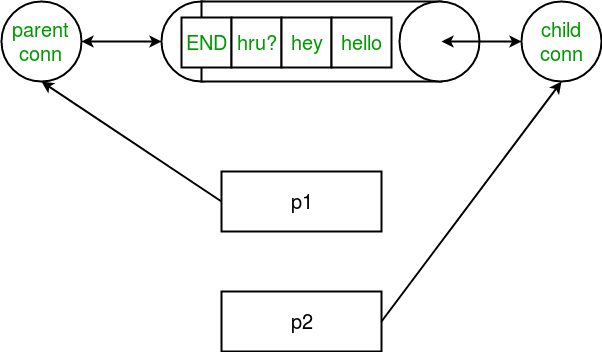

In [1]:
import random
from multiprocessing import Process, Queue, Pipe
import sys
import time #For the timestamp and sleep function
if sys.platform == "win32":
    # On Windows, the best timer is time.clock()
    default_timer = time.clock
else:
    # On most other platforms, the best timer is time.time()
    default_timer = time.time

def pa(child_conn, parent_q):
    keep_running = True
    while keep_running:
        r = random.randint(0,10)
        if r == 10:
            parent_q.put([0, default_timer()])
        if child_conn.poll():
            msg = child_conn.recv()
            this_time = default_timer()
            if msg == 'quit':
                keep_running = False
            else:
                print this_time - msg

def pb(child_conn, parent_q):
    keep_running = True
    while keep_running:
        r = random.randint(0,10)
        if r == 10:
            parent_q.put([1, default_timer()])
        if child_conn.poll():
            msg = child_conn.recv()
            this_time = default_timer()
            if msg == 'quit':
                keep_running = False
            else:  
                print this_time - msg
    

if __name__ == '__main__':
    parent_conn0, child_conn0 = Pipe()
    parent_conn1, child_conn1 = Pipe()
    parent_q = Queue()
    p0 = Process(target=pa, args=(child_conn0, parent_q))
    p0.start()
    p1 = Process(target=pb, args=(child_conn1, parent_q))
    p1.start()
    keep_running = True
    while keep_running:
        ans = parent_q.get() # Blocking get
        this_time = default_timer()
        print(ans[0], this_time - ans[1])
        r = random.randint(0,20)
        if r == 10:
            parent_conn0.send('quit')
            parent_conn1.send('quit')
            keep_running = False
        else:
            parent_conn0.send(default_timer())
            parent_conn0.send(default_timer())
    p0.join()
    p1.join()

9.48905944824e-05
0.00908398628235
0.0135841369629
0.0171611309052
0.0200011730194
0.0242128372192
0.0264618396759
0.0316610336304
0.0344798564911
0.0388178825378
0.0431010723114
0.046037197113
0.0495488643646
0.0528440475464
0.056972026825
0.0599360466003
0.0630559921265
0.0657181739807
0.0680620670319
0.0709049701691
0.0740120410919
0.076623916626
0.079066991806
0.0820689201355
0.0853588581085
0.0884990692139
0.0911569595337
0.0939629077911
0.0967259407043
0.0998439788818
0.102437019348
0.105307817459
0.108021020889
0.110898017883
0.113418102264
0.117795944214
0.124101877213
0.129719018936
0.132791996002
0.136101961136
0.143686056137
0.147948026657
0.150674104691
0.153499126434
0.157027959824
0.15985584259
0.16263794899
0.165544033051
0.168145895004
0.172059059143
0.175159931183
0.178770065308
0.182589054108
0.185470104218
0.188155889511
0.191532850266
0 0.00215196609497
0 0.00239300727844
0 0.00244498252869
1 0.0022919178009
1 0.000534057617188
1 0.000603914260864
1 0.00057911872863

A pipe has a limited capacity in Linux. When the pipe is full, a `write(2)` will block (or fail if the `O_NONBLOCK` flag is set). Different implementations of pipes have different limits, so applications shouldn’t rely on a pipe having a particular size. Applications should be designed to consume data as soon as it is available so the writing process doesn’t block. That said, knowing the pipe size is useful. Since Linux 2.6.35, the default pipe capacity is 65,536 bytes 

In [ ]:
def convert(self):
    logging.info('Converting with params: %s' % (str(self.params)))
    cmd = self.get_cmd(self.params)
    output = []
    p = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        close_fds=True,
    )
    # start child output draining thread to avoid hang on full buffer
    drainerthread = threading.Thread(target=output.extend, args=(p.stdout,))
    drainerthread.daemon = True
    drainerthread.start()
    deadline = time.time() + 30 * 60
    while time.time() < deadline and p.poll() is None:
        time.sleep(1)

    ret_code = 42
    if p.poll() is None:
        p.kill()
    else:
        logging.info("Wait on ffmpeg")
        p.wait()
        logging.info("Join pipe's output draining thread")
        drainerthread.join()
        log = '\n'.join(output)
        logging.info(log)
        ret_code = p.returncode

    if ret_code:
        logging.error("ffmpeg exited wiht non-zero return code: %s" % ret_code)
    return ret_code

If a process A is writing data at roughly the same speed as process B is reading it, pipes work very well and are highly performance. An imbalance here can cause performance problems

__Queue__

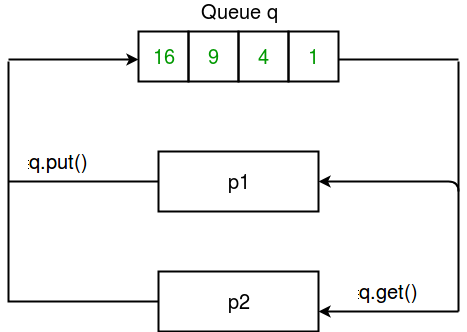

In [1]:
import multiprocessing as mp
import random
import string

random.seed(123)

# Define an output queue
output = mp.Queue()

# define a example function
def rand_string(length, output):
    """ Generates a random string of numbers, lower- and uppercase chars. """
    rand_str = ''.join(random.choice(
                        string.ascii_lowercase
                        + string.ascii_uppercase
                        + string.digits)
                   for i in range(length))
    output.put(rand_str)

# Setup a list of processes that we want to run
processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

['RhPcf', '0ft7T', 'Q8hfh', 'Fmrw1']


It is worth noting that each process we create consumes some RAM from the system. You can expect a forked process using the standard libraries to take on the order of 10–20MB of RAM; if you’re using many libraries and lots of data, then you might expect each forked copy to take hundreds of megabytes

__Note__: pool methods all use a Queue to pass tasks to the worker processes. Everything that goes through the Queue must be pickable

### COW

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
 
from multiprocessing import Pool
from time import sleep
 
# The size of the cache created when calling range(CACHE). To ensure that your
# processes is visible on your system, you will need to adjust this value.
# Start with the CACHE value below and keep adding 0s until anywhere between
# 5-10% of your memory is consumed. You may also want to reduce the PAUSE
# value below to make this tuning easier. Note that IT IS VERY EASY TO RUN
# YOUR SYSTEM OUT OF MEMORY THIS WAY, so save everything before attempting.
CACHE = 10000
 
# The number of subprocesses forked.
PROCESSES = 5
 
# The number of seconds to pause in order to display the allocated memory in
# the system monitor.
PAUSE = 3
 
def job(cache):
    '''
    An artificial job that sleeps for a second and then reports memory usage.
    '''
    # Read all of the data in the cache. Note that in order to see the effect
    # the copy on write problem, we need to actually read the cache. By reading
    # the cache, we create a new reference to the memory being tracked and
    # therefore copy the memory although all we're doing is reading.
    for item in cache:
        pass
 
    # Make sure the memory that the allocated memory is visible in the system
    # monitor.
    sleep(PAUSE)

def main():
    '''
    Entry point.
    '''
    # Create the cache. Note that allocating a large amount of memory takes
    # time. After the memory is allocated, we want to make sure the new memory
    # level is visible in the system monitor, so we pause.
    cache = range(CACHE)
    sleep(PAUSE)
 
    # Run the jobs.
    pool = Pool(PROCESSES)
    pool.map(job, [cache]*PROCESSES)

if __name__ == '__main__':
    main()

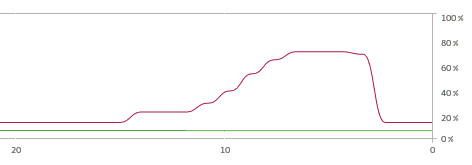

### Shared memory

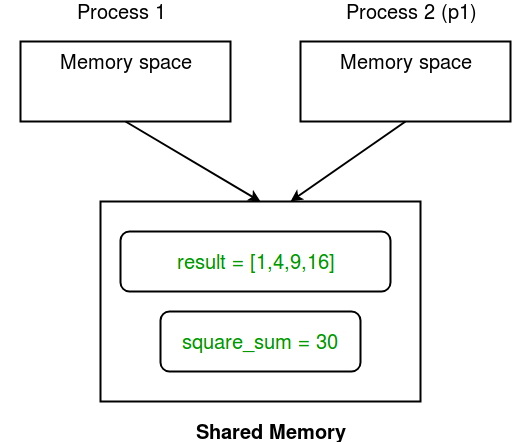

__Value__

In [ ]:
import math
import timeit
from multiprocessing import Pool
import multiprocessing
import create_range


SERIAL_CHECK_CUTOFF = 21
CHECK_EVERY = 1000
FLAG_CLEAR = b'0'
FLAG_SET = b'1'
print("CHECK_EVERY", CHECK_EVERY


def check_prime_in_range(args):
    (n, (from_i, to_i), value) = args
    if n % 2 == 0:
        return False
    check_every = CHECK_EVERY
    for i in xrange(from_i, int(to_i), 2):
        check_every -= 1
        if not check_every:
            if value.value == FLAG_SET:
                return False
            check_every = CHECK_EVERY

        if n % i == 0:
            value.value = FLAG_SET
            return False
    return True


def check_prime(n, pool, nbr_processes, value):
    # cheaply check high probability set of possible factors
    from_i = 3
    to_i = SERIAL_CHECK_CUTOFF
    value.value = FLAG_CLEAR
    if not check_prime_in_range((n, (from_i, to_i), value)):
        return False
    value.value = FLAG_CLEAR

    from_i = to_i
    to_i = int(math.sqrt(n)) + 1

    ranges_to_check = create_range.create(from_i, to_i, nbr_processes)
    ranges_to_check = zip(
        len(ranges_to_check) * [n],
        ranges_to_check,
        len(ranges_to_check) * [value])
    assert len(ranges_to_check) == nbr_processes
    results = pool.map(check_prime_in_range, ranges_to_check)
    if False in results:
        return False
    return True


if __name__ == "__main__":
    NBR_PROCESSES = 4
    value = multiprocessing.Value(b'c', FLAG_CLEAR)  # 1 byte character
    pool = Pool(processes=NBR_PROCESSES)
    print("Testing with {} processes".format(NBR_PROCESSES))
    labeled_numbers = [
        ("trivial non-prime", 112272535095295),
        ("expensive non-prime18_1", 100109100129100369),
        ("expensive non-prime18_2", 100109100129101027),
        ("prime18_1", 100109100129100151),
        ("prime18_2", 100109100129162907),
    ]
    for label, nbr in labeled_numbers:
        time_costs = timeit.repeat(
            stmt="check_prime({}, pool, {}, value)".format(nbr, NBR_PROCESSES),
            repeat=20,
            number=1,
            setup="from __main__ import pool, check_prime, value")
        print("{:19} ({}) {: 3.6f}s".format(label, nbr, min(time_costs)))

__Array__

In [2]:
import multiprocessing
 
def square_list(mylist, result, square_sum):
    """
    function to square a given list
    """
    # append squares of mylist to result array
    for idx, num in enumerate(mylist):
        result[idx] = num * num
 
    # square_sum value
    square_sum.value = sum(result)
 
    # print result Array
    print("Result(in process p1): {}".format(result[:]))
 
    # print square_sum Value
    print("Sum of squares(in process p1): {}".format(square_sum.value))

if __name__ == "__main__":
    # input list
    mylist = [1,2,3,4]
 
    # creating Array of int data type with space for 4 integers
    result = multiprocessing.Array('i', 4)
 
    # creating Value of int data type
    square_sum = multiprocessing.Value('i')
 
    # creating new process
    p1 = multiprocessing.Process(target=square_list, args=(mylist, result, square_sum))
 
    # starting process
    p1.start()
 
    # wait until process is finished
    p1.join()
 
    # print result array
    print("Result(in main program): {}".format(result[:]))
 
    # print square_sum Value
    print("Sum of squares(in main program): {}".format(square_sum.value))

Result(in process p1): [1, 4, 9, 16]
Sum of squares(in process p1): 30
Result(in main program): [1, 4, 9, 16]
Sum of squares(in main program): 30


__mmap__

In [ ]:
"""Check primality by splitting the list of factors with early prime check and mmap flag"""

import math
import timeit
from multiprocessing import Pool
import create_range
import mmap


SERIAL_CHECK_CUTOFF = 21
CHECK_EVERY = 1000
FLAG_CLEAR = b'0'
FLAG_SET = b'1'
print("CHECK_EVERY", CHECK_EVERY)

sh_mem = mmap.mmap(-1, 1)  # memory map 1 byte as a flag


def check_prime_in_range(args):
    (n, (from_i, to_i)) = args
    if n % 2 == 0:
        return False
    for outer_counter in xrange(from_i, int(to_i), CHECK_EVERY):
        upper_bound = min(int(to_i), outer_counter + CHECK_EVERY)
        for i in xrange(outer_counter, upper_bound, 2):
            if n % i == 0:
                sh_mem.seek(0)
                sh_mem.write_byte(FLAG_SET)
                return False
        sh_mem.seek(0)
        flag = sh_mem.read_byte()
        if flag == FLAG_SET:
            return False
    return True


def check_prime(n, pool, nbr_processes):
    # cheaply check high probability set of possible factors
    from_i = 3
    to_i = SERIAL_CHECK_CUTOFF
    sh_mem.seek(0)
    sh_mem.write_byte(FLAG_CLEAR)
    if not check_prime_in_range((n, (from_i, to_i))):
        return False
    sh_mem.seek(0)
    sh_mem.write_byte(FLAG_CLEAR)

    from_i = to_i
    to_i = int(math.sqrt(n)) + 1

    ranges_to_check = create_range.create(from_i, to_i, nbr_processes)
    ranges_to_check = zip(len(ranges_to_check) * [n], ranges_to_check)
    assert len(ranges_to_check) == nbr_processes
    results = pool.map(check_prime_in_range, ranges_to_check)
    if False in results:
        return False
    return True

### Manager

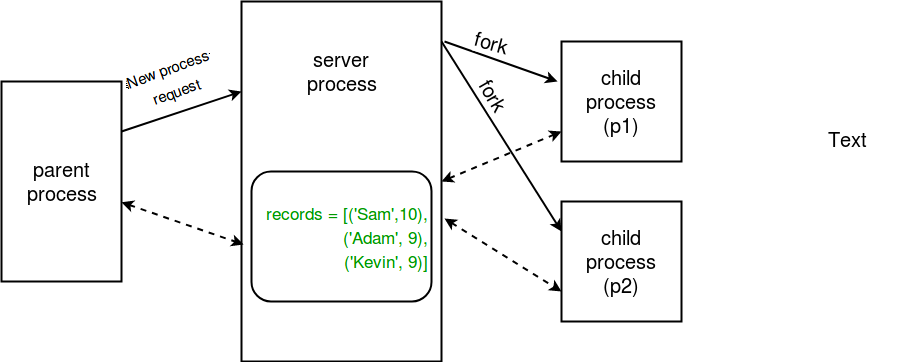

In [3]:
import multiprocessing
 
def print_records(records):
    """
    function to print record(tuples) in records(list)
    """
    for record in records:
        print("Name: {0}\nScore: {1}\n".format(record[0], record[1]))

def insert_record(record, records):
    """
    function to add a new record to records(list)
    """
    records.append(record)
    print("New record added!\n")

if __name__ == '__main__':
    with multiprocessing.Manager() as manager:
        # creating a list in server process memory
        records = manager.list([('Sam', 10), ('Adam', 9), ('Kevin',9)])
        # new record to be inserted in records
        new_record = ('Jeff', 8)
 
        # creating new processes
        p1 = multiprocessing.Process(target=insert_record, args=(new_record, records))
        p2 = multiprocessing.Process(target=print_records, args=(records,))
 
        # running process p1 to insert new record
        p1.start()
        p1.join()
 
        # running process p2 to print records
        p2.start()
        p2.join()

New record added!

Name: Sam
Score: 10

Name: Adam
Score: 9

Name: Kevin
Score: 9

Name: Jeff
Score: 8



### Connection

In [ ]:
from multiprocessing.connection import Listener
from threading import Thread


def handle_client(c):
    while True:
        msg = c.recv()
        c.send(msg)


def echo_server(address, authkey):
    server_c = Listener(address, authkey=authkey)
    while True:
        client_c = server_c.accept()
        t = Thread(target=handle_client, args=(client_c,))
        t.daemon = True
        t.start()

if __name__ == '_ _main_ _':
    echo_server(("",16000), "peekaboo")

In [ ]:
>>> from multiprocessing.connection import Client
>>> c = Client(("localhost",16000), authkey="peekaboo")
>>> c.send("Hello")
>>> c.recv()
"Hello"
>>> c.send([1,2,3,4])
>>> c.recv()
[1, 2, 3, 4]
>>> c.send({"name":"Dave","email":"dave@dabeaz.com"})
>>> c.recv()
{"name": "Dave", "email": "dave@dabeaz.com"}

In [ ]:
# rpcserver.py
from multiprocessing.connection import Listener, Client
from threading import Thread

class RPCServer(object):
    def __init__(self, address, authkey):
        self._functions = {}
        self._server_c = Listener(address, authkey=authkey)

    def register_function(self, func):
        self._functions[func.__name__] = func

    def serve_forever(self):
        while True:
            client_c = self._server_c.accept()
            t = Thread(target=self.handle_client, args=(client_c,))
            t.daemon = True
            t.start()

    def handle_client(self, client_c):
        while True:
            func_name, args, kwargs = client_c.recv()
            try:
                r = self._functions[func_name](*args, **kwargs)
                client_c.send(r)
            except Exception as e:
                client_c.send(e)


class RPCProxy(object):
    def __init__(self, address, authkey):
        self._conn = Client(address, authkey=authkey)

    def __getattr__(self, name):
        def do_rpc(*args, **kwargs):
            self._conn.send((name, args, kwargs))
            result = self._conn.recv()
            if isinstance(result, Exception):
                raise result
            return result
        return do_rpc
    
    
    
if __name__ == '__main__':
    def add(x, y):
        return x + y
    def sub(x, y):
        return x - y

    # Create and run the server
    serv = RPCServer(("localhost", 17000), authkey="peekaboo")
    serv.register_function(add)
    serv.register_function(sub)
    serv.serve_forever()

In [ ]:
>>> from rserver import RPCProxy
>>> c = RPCProxy(("localhost", 17000), authkey="peekaboo")
>>> c.add(2, 3)
5
>>> c.sub(2, 3)
-1
>>> c.sub([1, 2], 4)
Traceback (most recent call last):
 File "", line 1, in
 File "rpcserver.py", line 37, in do_rpc
 raise result
TypeError: unsupported operand type(s) for -: ‘list’ and ‘int’
>>> 

### References

* https://en.wikipedia.org/wiki/Amdahl%27s_law
* http://www.dabeaz.com/GIL/gilvis/index.html
* http://eli.thegreenplace.net/2012/01/04/shared-counter-with-pythons-multiprocessing/
* https://www.laurentluce.com/posts/python-threads-synchronization-locks-rlocks-semaphores-conditions-events-and-queues/
* https://www.usenix.org/system/files/login/articles/login1210_beazley.pdf
* https://superfastpython.com/multiprocessing-in-python/
* https://www.geeksforgeeks.org/multiprocessing-python-set-2/
* https://eli.thegreenplace.net/2012/01/24/distributed-computing-in-python-with-multiprocessing
* http://bhfsteve.blogspot.ru/2013/02/fun-with-pythons-multiprocessing-module.html
* https://llvllatrix.wordpress.com/2016/02/19/python-vs-copy-on-write/
* https://brandonwamboldt.ca/how-linux-pipes-work-under-the-hood-1518/
* https://www.cloudcity.io/blog/2019/02/27/things-i-wish-they-told-me-about-multiprocessing-in-python/
* https://realpython.com/python-parallel-processing/
* https://pythonspeed.com/articles/faster-multiprocessing-pickle/

### Summary

* use threads for I/O-intensive jobs and processes for CPU-intensive
* look for "embarrassingly parallel" tasks
* any synchronization or IPC comes at costs
* "more workers" doesn't always imply "more speed"